<h1>Encodings for Next Step Activity Prediction</h1>

<h5>Lorenzo Manuel Cirac Monteagudo</h5>
<h5>Supervisor: Ana Luisa Oliveira da Nobrega Costa</h5>
<h5>Chair: Information Systems</h5>
<h5>TUM School of Computation, Information and Technology</h5>

In [1]:
import pandas as pd
import numpy as np
import pm4py
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

<h3>Dataset Exploration</h3>
<p>Helpdesk dataset: <a href="https://github.com/ERamaM/PredictiveMonitoringDatasets/tree/master/raw_datasets">https://github.com/ERamaM/PredictiveMonitoringDatasets/tree/master/raw_datasets</a></p>
<p>This dataset contains events from a ticketing management process of the help desk of an Italian software company. </p>

In [2]:
from pm4py.objects.conversion.log import converter as xes_converter
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.filtering.log.cases import case_filter
import random

log = xes_importer.apply("data/helpdesk")
df = xes_converter.apply(log, variant=xes_converter.Variants.TO_DATA_FRAME)

parsing log, completed traces ::   0%|          | 0/4580 [00:00<?, ?it/s]

In [3]:
df.columns

Index(['concept:name', 'lifecycle:transition', 'org:resource',
       'time:timestamp', 'Activity', 'Resource', 'case:concept:name',
       'case:variant', 'case:variant-index', 'case:creator'],
      dtype='object')

In [4]:
df["concept:name"].unique()

array(['Assign seriousness', 'Take in charge ticket', 'Resolve ticket',
       'Closed', 'Wait', 'Create SW anomaly', 'Insert ticket',
       'Schedule intervention', 'RESOLVED', 'INVALID', 'VERIFIED',
       'Resolve SW anomaly', 'Require upgrade', 'DUPLICATE'], dtype=object)

In [5]:
from collections import Counter, defaultdict

# basic stats
total_events = sum(len(trace) for trace in log)
print(f"Cases: {len(log)}")
print(f"Events: {total_events}")
print(f"Activities: {len(pm4py.get_event_attribute_values(log, "concept:name"))}")
print(f"Variants: {len(pm4py.stats.get_variants(log))}")
print(f"Average case length: {total_events / len(log):.2f} events per case")

# top 5 most common activities
activities = pm4py.get_event_attribute_values(log, "concept:name")
activity_counter = Counter(activities)
print("\nMost common activities:")
for i, (activity, count) in enumerate(activity_counter.most_common(5), 1):
    print(f"{i}. {activity}: {count}")

# most common activities by position
positions = defaultdict(Counter)
for trace in log:
    for position, event in enumerate(trace):
        positions[position][event["concept:name"]] += 1

print("\nMost common by position:")
for position in range(min(5, len(positions))):
    if position in positions:
        activity, count = positions[position].most_common(1)[0]
        percentage = count / len(log) * 100
        print(f"{position + 1}. {activity} ({count} cases, {percentage:.1f}%)")

Cases: 4580
Events: 21348
Activities: 14
Variants: 226
Average case length: 4.66 events per case

Most common activities:
1. Take in charge ticket: 5060
2. Resolve ticket: 4983
3. Assign seriousness: 4938
4. Closed: 4574
5. Wait: 1463

Most common by position:
1. Assign seriousness (4384 cases, 95.7%)
2. Take in charge ticket (3712 cases, 81.0%)
3. Resolve ticket (2713 cases, 59.2%)
4. Closed (2504 cases, 54.7%)
5. Closed (1091 cases, 23.8%)


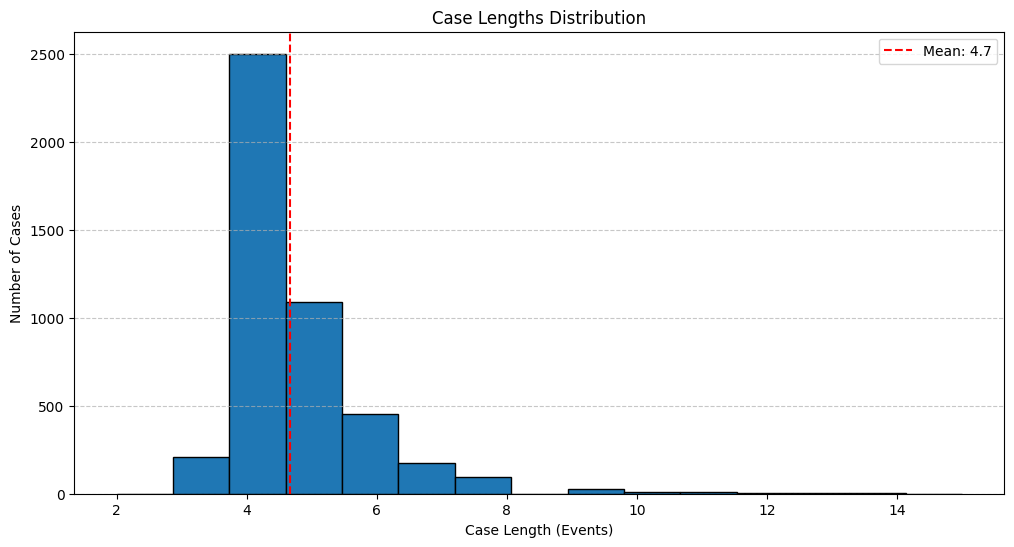

In [6]:
case_lengths = df.groupby("case:concept:name").size()
mean_length = case_lengths.mean()

plt.figure(figsize=(12, 6))
plt.hist(case_lengths, bins=15, edgecolor="black")
plt.axvline(mean_length, color="red", linestyle="--", label=f"Mean: {mean_length:.1f}")
plt.title("Case Lengths Distribution")
plt.xlabel("Case Length (Events)")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

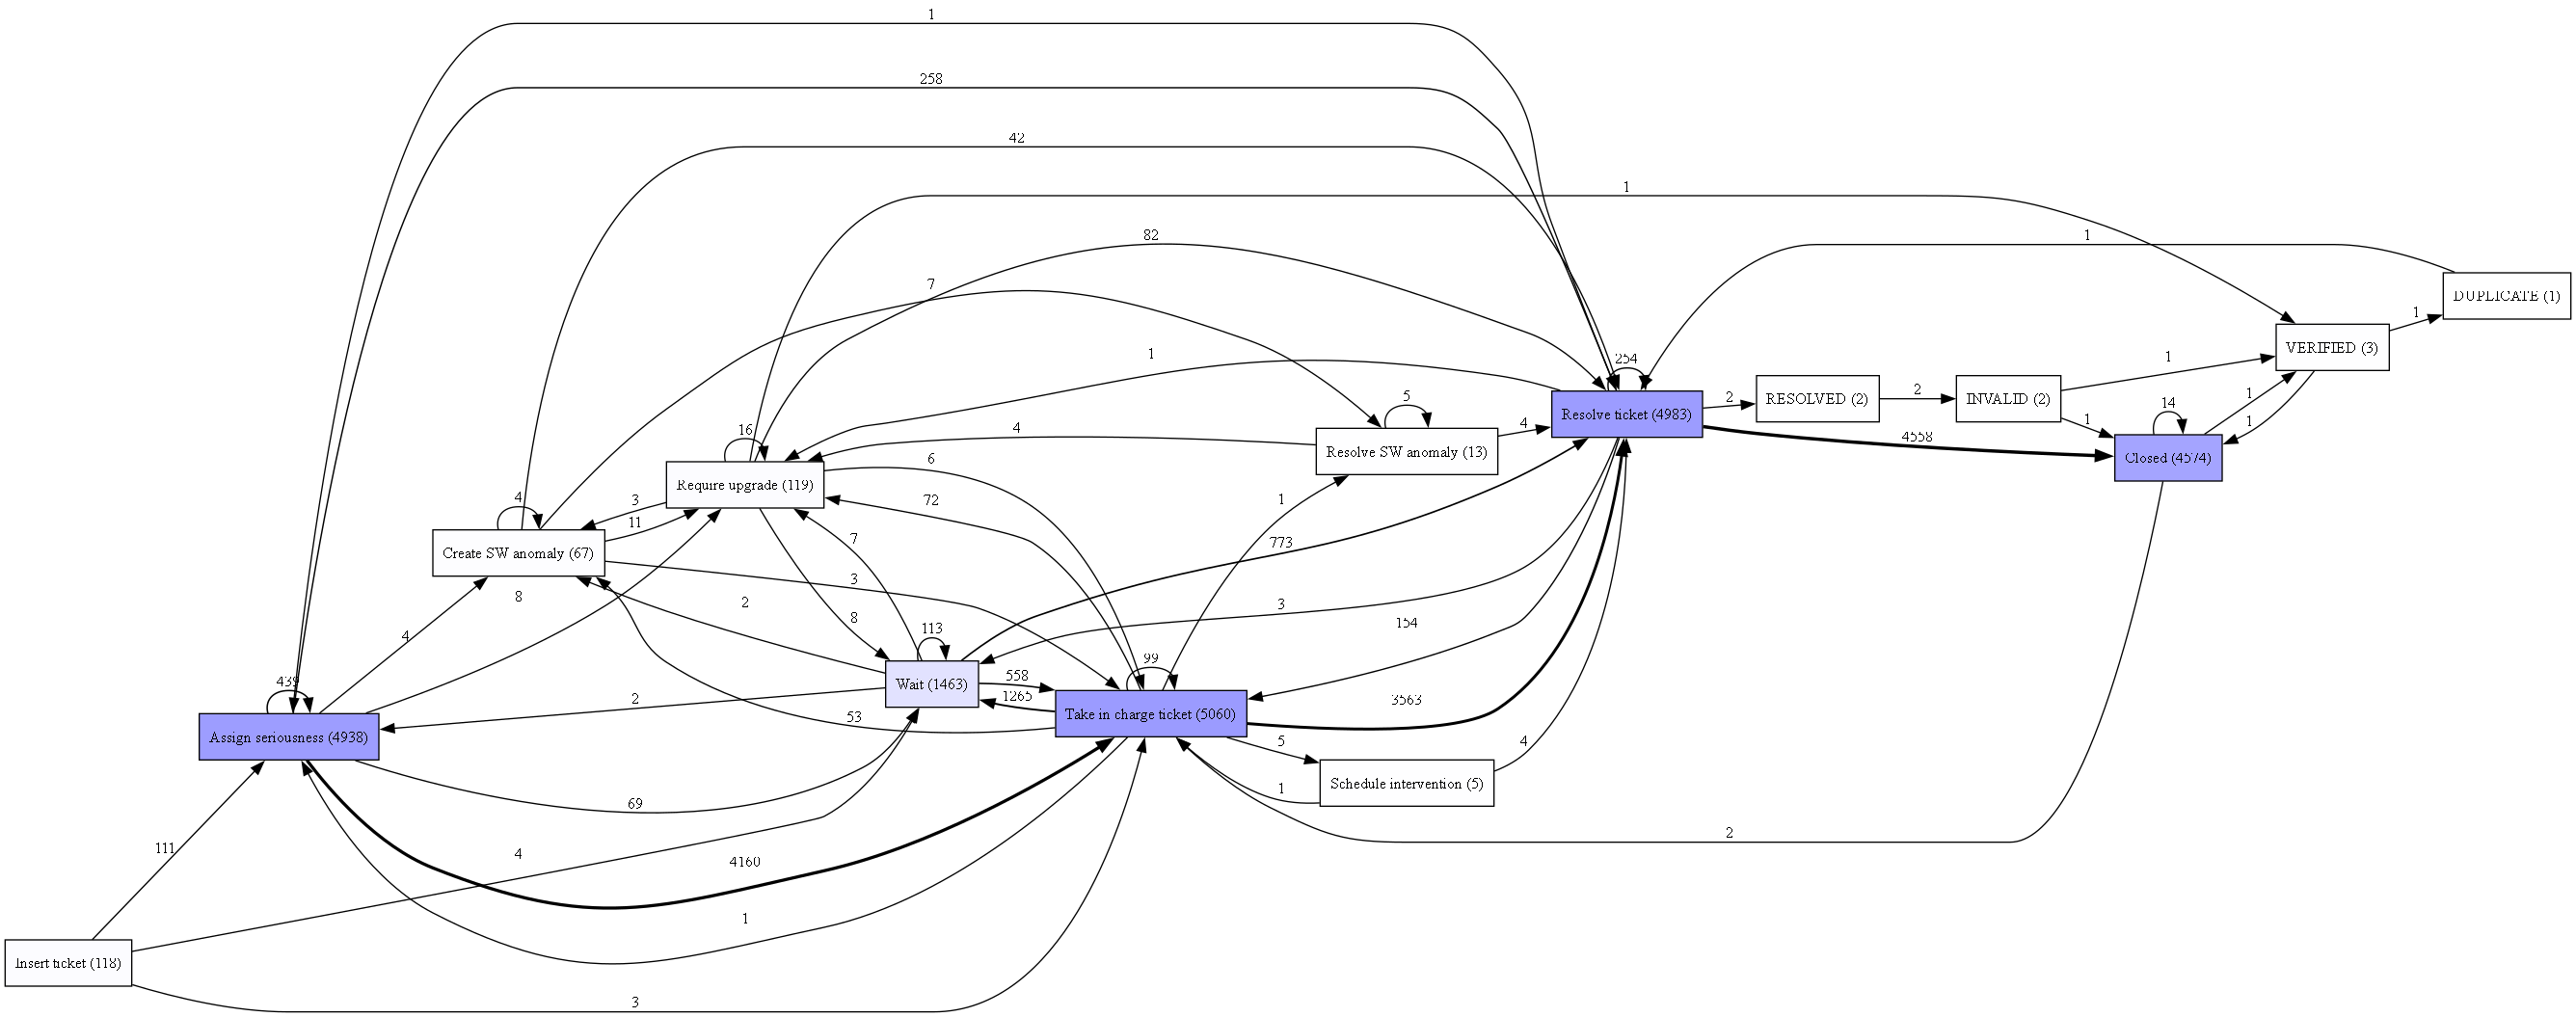

In [7]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_vis

dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.FREQUENCY)
gviz = dfg_vis.apply(dfg, log=log, variant=dfg_vis.Variants.FREQUENCY)

dfg_vis.view(gviz)

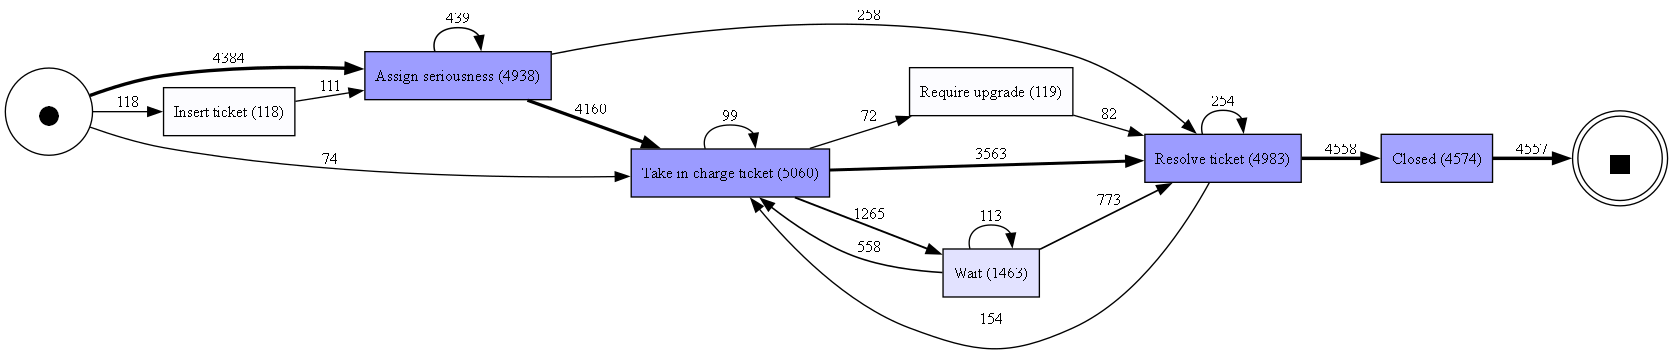

In [8]:
from pm4py.algo.filtering.dfg import dfg_filtering
from pm4py.statistics.attributes.log import get as attributes_get
from pm4py.statistics.start_activities.log import get as start_activities_get
from pm4py.statistics.end_activities.log import get as end_activities_get

start_activities = start_activities_get.get_start_activities(log)
end_activities = end_activities_get.get_end_activities(log)
activities_count = attributes_get.get_attribute_values(log, "concept:name")

# filter the dfg to keep 25% of paths
filtered_dfg, filtered_start_activities, filtered_end_activities, filtered_activities_count = \
    dfg_filtering.filter_dfg_on_paths_percentage(
        dfg, 
        start_activities, 
        end_activities, 
        activities_count, 
        0.25
    )

gviz = dfg_vis.apply(filtered_dfg, 
                     log=log, 
                     variant=dfg_vis.Variants.FREQUENCY,
                     parameters={"start_activities": filtered_start_activities,
                               "end_activities": filtered_end_activities})
dfg_vis.view(gviz)

<h3>Data Preparation</h3>

In [9]:
# clean data
df = df.rename(columns = {
    "case:concept:name": "case_id",
    "concept:name": "activity", 
    "org:resource": "resource",
    "time:timestamp": "timestamp"
})

required_cols = ["case_id", "activity", "timestamp"]
optional_cols = ["resource"]

cols_to_select = required_cols.copy()
for col in optional_cols:
    if col in df.columns:
        cols_to_select.append(col)
        
df = df[cols_to_select]

# target (y)
df["next_activity"] = df.groupby("case_id")["activity"].shift(-1)

# sort by timestamp
df = df.sort_values(by = ["case_id", "timestamp"])

df.head(10)

,case_id,activity,timestamp,resource,next_activity
17612,Case1,Assign seriousness,2012-10-09 14:50:17+00:00,Value 1,Take in charge ticket
17613,Case1,Take in charge ticket,2012-10-09 14:51:01+00:00,Value 1,Take in charge ticket
17614,Case1,Take in charge ticket,2012-10-12 15:02:56+00:00,Value 2,Resolve ticket
17615,Case1,Resolve ticket,2012-10-25 11:54:26+00:00,Value 1,Closed
17616,Case1,Closed,2012-11-09 12:54:39+00:00,Value 3,NaN
212,Case10,Assign seriousness,2010-02-10 08:50:20+00:00,Value 2,Take in charge ticket
213,Case10,Take in charge ticket,2010-03-19 08:47:06+00:00,Value 2,Resolve ticket
214,Case10,Resolve ticket,2010-03-19 08:47:13+00:00,Value 2,Closed
215,Case10,Closed,2010-04-03 07:47:38+00:00,Value 5,NaN
19330,Case100,Assign seriousness,2013-04-12 10:25:17+00:00,Value 1,Take in charge ticket


In [10]:
# add prefix
prefixes = []
for case_id, group in df.groupby("case_id"):
    activities = group["activity"].astype(str).tolist()
    resources = group["resource"].astype(str).tolist()
    timestamps = group["timestamp"].tolist()
    
    for i in range(1, len(activities)):   
        prefixes.append({
            "case_id": case_id,
            "step": i,
            "activities": activities[:i],
            "resources": resources[:i],
            "next_activity": activities[i],
        })

# fix types
df = pd.DataFrame(prefixes)
df["case_id"] = df["case_id"].astype(str)
df["step"] = df["step"].astype(int)
df["activities"] = df["activities"].astype(object)
df["resources"] = df["resources"].astype(object)  
df["next_activity"] = df["next_activity"].astype(str)

In [11]:
from sklearn.preprocessing import LabelEncoder

X = df.drop(columns = ["case_id", "next_activity"])
y = df["next_activity"]

le = LabelEncoder()
y = le.fit_transform(df["next_activity"])

<h3>Encodings</h3>

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder

<h4>One-hot Encoding</h4>
<p>One-hot encoding converts categorical data into a numerical format by creating one binary feature per unique category. Each feature indicates the presence (1) or absence (0) of the category in the observation.</p>

In [13]:
def one_hot_encoding(X):

    X_copy = X.copy()
    numerical_cols = [col for col in X.columns if pd.api.types.is_numeric_dtype(X[col])]
    non_numerical_cols = [col for col in X.columns if not pd.api.types.is_numeric_dtype(X[col])]
    
    encoded_dfs = []
    if numerical_cols:
        encoded_dfs.append(X_copy[numerical_cols])
    
    for col in non_numerical_cols:
        mlb = MultiLabelBinarizer()
        encoded_data = mlb.fit_transform(X_copy[col])

        col_names = [f"{col}_{cls}" for cls in mlb.classes_]
        encoded_df = pd.DataFrame(encoded_data, columns=col_names, index=X_copy.index)
        encoded_dfs.append(encoded_df)
    
    X_encoded = pd.concat(encoded_dfs, axis=1)
    
    return X_encoded

In [14]:
one_hot_encoding(X)

,step,activities_Assign seriousness,activities_Closed,activities_Create SW anomaly,activities_DUPLICATE,activities_INVALID,activities_Insert ticket,activities_RESOLVED,activities_Require upgrade,activities_Resolve SW anomaly,...,resources_Value 20,resources_Value 21,resources_Value 22,resources_Value 3,resources_Value 4,resources_Value 5,resources_Value 6,resources_Value 7,resources_Value 8,resources_Value 9
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16763,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16764,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16765,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16766,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h4>Last State Encoding</h4>
<p>Last state encoding represents only the most recent events in a sequence. The last n events are selected, and each position is separately one-hot encoded to preserve their order.</p>

In [15]:
def last_state_encoding(X, n=1):
    X_copy = X.copy()
    numerical_cols = [col for col in X.columns if pd.api.types.is_numeric_dtype(X[col])]
    non_numerical_cols = [col for col in X.columns if not pd.api.types.is_numeric_dtype(X[col])]
    
    def extract_last_state(data):
        features = {}

        # keep numerical columns
        for col in numerical_cols:
            features[col] = data[col]
        
        # extract last n states from non-numerical col
        for col in non_numerical_cols:
            last_states = data[col].apply(
                lambda x: (["None"] * max(0, n - len(x)) + x)[-n:]
            )
            for i in range(n):
                features[f"last_{col}_{i+1}"] = last_states.apply(lambda x: x[i])
        
        return pd.DataFrame(features, index=data.index)
    
    X_new = extract_last_state(X_copy)
    
    # one hot encode categorical cols (extracted last states)
    categorical_cols = [col for col in X_new.columns if col not in numerical_cols]
    
    encoded_dfs = []
    if numerical_cols:
        encoded_dfs.append(X_new[numerical_cols])
    
    if categorical_cols:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        encoded_data = encoder.fit_transform(X_new[categorical_cols])
        col_names = encoder.get_feature_names_out(categorical_cols)
        encoded_df = pd.DataFrame(encoded_data, columns=col_names, index=X_new.index)
        encoded_dfs.append(encoded_df)
    
    X_encoded = pd.concat(encoded_dfs, axis=1)
    
    return X_encoded

In [16]:
last_state_encoding(X)

,step,last_activities_1_Assign seriousness,last_activities_1_Closed,last_activities_1_Create SW anomaly,last_activities_1_DUPLICATE,last_activities_1_INVALID,last_activities_1_Insert ticket,last_activities_1_RESOLVED,last_activities_1_Require upgrade,last_activities_1_Resolve SW anomaly,...,last_resources_1_Value 20,last_resources_1_Value 21,last_resources_1_Value 22,last_resources_1_Value 3,last_resources_1_Value 4,last_resources_1_Value 5,last_resources_1_Value 6,last_resources_1_Value 7,last_resources_1_Value 8,last_resources_1_Value 9
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16763,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16764,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16765,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16766,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h4>Index Encoding</h4>
<p>Index encoding assigns each event to its specific position in the trace, treating each position as a separate feature. One-hot encoding is applied at each position to fully preserve the event order.</p>

In [17]:
def index_encoding(X, max_length=10):
    X_copy = X.copy()
    numerical_cols = [col for col in X.columns if pd.api.types.is_numeric_dtype(X[col])]
    non_numerical_cols = [col for col in X.columns if not pd.api.types.is_numeric_dtype(X[col])]
    
    if max_length is None:
        max_length = max([X_copy[col].apply(len).max() for col in non_numerical_cols])
        
    def extract_index_features(data):
        features = {}
        
        # keep numerical columns
        for col in numerical_cols:
            features[col] = data[col]
        
        # extract index features from non-numerical columns
        for col in non_numerical_cols:
            padded_lists = data[col].apply(
                lambda x: (x + ["None"] * max_length)[:max_length]
            )
            for i in range(max_length):
                features[f"{col}_{i+1}"] = padded_lists.apply(lambda x: x[i])
        
        return pd.DataFrame(features, index=data.index)
    
    X_new = extract_index_features(X_copy)
    
    # one hot encode the categorical columns (the extracted index features)
    categorical_cols = [col for col in X_new.columns if col not in numerical_cols]
    
    encoded_dfs = []
    if numerical_cols:
        encoded_dfs.append(X_new[numerical_cols])
    
    if categorical_cols:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        encoded_data = encoder.fit_transform(X_new[categorical_cols])
        col_names = encoder.get_feature_names_out(categorical_cols)
        encoded_df = pd.DataFrame(encoded_data, columns=col_names, index=X_new.index)
        encoded_dfs.append(encoded_df)
    
    X_encoded = pd.concat(encoded_dfs, axis=1)
    
    return X_encoded

In [18]:
index_encoding(X)

,step,activities_1_Assign seriousness,activities_1_Create SW anomaly,activities_1_Insert ticket,activities_1_Resolve ticket,activities_1_Take in charge ticket,activities_1_Wait,activities_2_Assign seriousness,activities_2_Create SW anomaly,activities_2_None,...,resources_9_Value 9,resources_10_None,resources_10_Value 13,resources_10_Value 14,resources_10_Value 15,resources_10_Value 16,resources_10_Value 2,resources_10_Value 6,resources_10_Value 7,resources_10_Value 9
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16763,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16764,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16765,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16766,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h4>Inter Case Encoding</h4>
<p>Inter-case encoding adds contextual information from other running cases to each event’s representation.</p>

In [19]:
def inter_case_encoding(X):
    X_copy = X.copy()
    numerical_cols = [col for col in X.columns if pd.api.types.is_numeric_dtype(X[col])]
    non_numerical_cols = [col for col in X.columns if not pd.api.types.is_numeric_dtype(X[col])]
    
    # calculate frequency counts for non-numerical columns (counting lists as whole units)
    frequency_features = {}
    for col in non_numerical_cols:
        col_values = X_copy[col].apply(lambda x: tuple(x) if isinstance(x, list) else x)
        frequency_counts = col_values.value_counts().to_dict()
        frequency_features[f"{col}_frequency"] = col_values.apply(lambda x: frequency_counts[x])
    
    frequency_df = pd.DataFrame(frequency_features, index=X_copy.index)
    
    encoded_dfs = []

    if numerical_cols:
        encoded_dfs.append(X_copy[numerical_cols])
    
    # add frequency features
    if frequency_features:
        encoded_dfs.append(frequency_df)
    
    # one hot encode non-numerical columns
    for col in non_numerical_cols:
        mlb = MultiLabelBinarizer()
        encoded_data = mlb.fit_transform(X_copy[col])
        col_names = [f"{col}_{cls}" for cls in mlb.classes_]
        encoded_df = pd.DataFrame(encoded_data, columns=col_names, index=X_copy.index)
        encoded_dfs.append(encoded_df)
    
    X_encoded = pd.concat(encoded_dfs, axis=1)
    
    return X_encoded

In [20]:
inter_case_encoding(X)

,step,activities_frequency,resources_frequency,activities_Assign seriousness,activities_Closed,activities_Create SW anomaly,activities_DUPLICATE,activities_INVALID,activities_Insert ticket,activities_RESOLVED,...,resources_Value 20,resources_Value 21,resources_Value 22,resources_Value 3,resources_Value 4,resources_Value 5,resources_Value 6,resources_Value 7,resources_Value 8,resources_Value 9
0,1,4384,1586,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,3706,577,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,72,48,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,37,11,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4384,656,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16763,3,958,8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16764,4,571,7,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16765,1,4384,1586,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16766,2,3706,31,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h4>Aggregation Encoding</h4>
<p>Aggregation encoding summarizes the entire prefix trace by computing statistical features over the sequence.</p>

In [21]:
from collections import Counter
from itertools import combinations

def aggregation_encoding(X):
    X_copy = X.copy()
    numerical_cols = [col for col in X.columns if pd.api.types.is_numeric_dtype(X[col])]
    non_numerical_cols = [col for col in X.columns if not pd.api.types.is_numeric_dtype(X[col])]
    
    def compute_aggregation_features(data):
        features = {}
        
        for col in numerical_cols:
            features[col] = data[col]
        
        # compute aggregation features for non-numerical columns
        for col in non_numerical_cols:
            col_data = data[col]
            features[f"unique_{col}"] = col_data.apply(lambda x: len(set(x)) if x else 0)
            features[f"most_frequent_{col}_count"] = col_data.apply(
                lambda x: max(Counter(x).values()) if x else 0
            )
        
        # compute ratios for all pairs of non-numerical columns
        for col1, col2 in combinations(non_numerical_cols, 2):
            features[f"{col1}_{col2}_ratio"] = data.apply(
                lambda row: len(set(row[col1])) / len(set(row[col2])) if len(set(row[col2])) > 0 else 0,
                axis=1
            )
        
        return pd.DataFrame(features, index=data.index)
    
    X_encoded = compute_aggregation_features(X_copy)
    
    return X_encoded

In [22]:
aggregation_encoding(X)

,step,unique_activities,most_frequent_activities_count,unique_resources,most_frequent_resources_count,activities_resources_ratio
0,1,1,1,1,1,1.0
1,2,2,1,1,2,2.0
2,3,2,2,2,2,1.0
3,4,3,2,2,3,1.5
4,1,1,1,1,1,1.0
...,...,...,...,...,...,...
16763,3,3,1,2,2,1.5
16764,4,4,1,2,3,2.0
16765,1,1,1,1,1,1.0
16766,2,2,1,2,1,1.0


<h4>Embeddings</h4>
<p>Embeddings are dense, low-dimensional numerical representations of categorical or textual data that capture the semantic meaning or relationships between items.</p>

In [23]:
from sentence_transformers import SentenceTransformer

def embedding_encoding(X, model_name="all-MiniLM-L12-v1"):
    X_copy = X.copy()
    numerical_cols = [col for col in X.columns if pd.api.types.is_numeric_dtype(X[col])]
    non_numerical_cols = [col for col in X.columns if not pd.api.types.is_numeric_dtype(X[col])]
    
    def lists_to_string(series):
        return series.apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
    
    model = SentenceTransformer(model_name)
    
    encoded_dfs = []
    
    if numerical_cols:
        encoded_dfs.append(X_copy[numerical_cols])
    
    # generate embeddings for non-numerical columns
    for col in non_numerical_cols:
        col_str = lists_to_string(X_copy[col])
        embeddings = model.encode(col_str.tolist())
        
        # create column names for embeddings (384 dimensions per column)
        embedding_dim = embeddings.shape[1] 
        col_names = [f"{col}_emb_{i}" for i in range(embedding_dim)]
        
        encoded_df = pd.DataFrame(embeddings, columns=col_names, index=X_copy.index)
        encoded_dfs.append(encoded_df)
    
    X_encoded = pd.concat(encoded_dfs, axis=1)
    
    return X_encoded

In [24]:
embedding_encoding(X)

,step,activities_emb_0,activities_emb_1,activities_emb_2,activities_emb_3,activities_emb_4,activities_emb_5,activities_emb_6,activities_emb_7,activities_emb_8,...,resources_emb_374,resources_emb_375,resources_emb_376,resources_emb_377,resources_emb_378,resources_emb_379,resources_emb_380,resources_emb_381,resources_emb_382,resources_emb_383
0,1,0.003831,0.005129,-0.051551,-0.021871,0.069599,-0.053350,0.081832,0.026581,-0.047898,...,0.027246,-0.009792,-0.008943,0.031404,-0.010499,0.013916,0.066067,-0.017299,0.024202,-0.018716
1,2,0.031616,0.019340,-0.035116,-0.014152,0.105390,-0.045988,0.140856,0.019199,-0.027401,...,0.020979,-0.026675,0.001933,0.041761,-0.026262,0.014995,0.065354,-0.015969,0.080730,-0.059347
2,3,0.039214,0.024875,-0.043401,-0.024861,0.091909,-0.047925,0.160204,0.000226,-0.009146,...,0.017722,0.000285,0.009155,0.050947,0.011480,-0.009813,0.079945,-0.020897,0.046547,-0.063593
3,4,0.027293,0.046610,-0.042189,-0.001707,0.046042,-0.079207,0.153928,0.001067,-0.003040,...,0.011300,0.016321,0.022564,0.039587,0.008065,-0.026962,0.080239,-0.000430,0.058955,-0.069762
4,1,0.003831,0.005129,-0.051551,-0.021871,0.069599,-0.053350,0.081832,0.026581,-0.047898,...,0.041833,-0.022673,-0.040520,0.047480,0.004334,0.013579,0.042319,-0.030091,-0.018409,-0.033666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16763,3,0.004664,-0.018175,-0.041137,-0.016827,0.095398,-0.030351,0.087400,0.028063,0.036919,...,0.009491,0.022980,-0.004887,0.047792,-0.004595,-0.027871,0.054101,-0.047540,0.019948,-0.060576
16764,4,-0.012083,0.013619,-0.043953,0.000691,0.056725,-0.061950,0.105037,0.028074,0.034756,...,0.019496,0.043744,0.012606,0.039323,-0.015334,-0.021293,0.069629,-0.033994,0.024097,-0.058952
16765,1,0.003831,0.005129,-0.051551,-0.021871,0.069599,-0.053350,0.081832,0.026581,-0.047898,...,0.027246,-0.009792,-0.008943,0.031404,-0.010499,0.013916,0.066067,-0.017299,0.024202,-0.018716
16766,2,0.031616,0.019340,-0.035116,-0.014152,0.105390,-0.045988,0.140856,0.019199,-0.027401,...,-0.019339,0.058987,-0.075025,0.033351,0.011845,-0.008799,0.068229,-0.059812,0.014914,-0.028355


<h3>Evaluation</h3>

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import time

results = []

param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5]
}

encodings = [
    one_hot_encoding, 
    last_state_encoding,
    index_encoding,
    inter_case_encoding,
    aggregation_encoding, 
    embedding_encoding
]

for encoding in encodings:
    
    encoding_start = time.perf_counter()
    X_encoded = encoding(X)
    encoding_time = time.perf_counter() - encoding_start
    
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=2025)
    
    training_start = time.perf_counter()
    rf = RandomForestClassifier(random_state=2025)
    grid_search = GridSearchCV(rf, param_grid, cv=3, scoring="f1_weighted", n_jobs=-1)
    grid_search.fit(X_train, y_train)
    training_time = time.perf_counter() - training_start
    
    best_model = grid_search.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")
    
    print(f"=== {encoding.__name__} ===")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Encoding Time: {encoding_time:.2f}s, Training Time: {training_time:.2f}s")
    print(f"Train: Accuracy={train_accuracy:.4f}, F1={train_f1:.4f}")
    print(f"Test:  Accuracy={test_accuracy:.4f}, F1={test_f1:.4f}")
    print()
    
    results.append({
        "encoding": encoding.__name__,
        "encoding_time": encoding_time,
        "training_time": training_time,
        "total_time": encoding_time + training_time,
        "best_params": grid_search.best_params_,
        "model": best_model,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "train_f1": train_f1,
        "test_f1": test_f1,
        "accuracy_gap": train_accuracy - test_accuracy,
        "f1_gap": train_f1 - test_f1
    })

=== one_hot_encoding ===
Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Encoding Time: 0.04s, Training Time: 14.07s
Train: Accuracy=0.8218, F1=0.7942
Test:  Accuracy=0.7898, F1=0.7543

=== last_state_encoding ===
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Encoding Time: 0.06s, Training Time: 3.83s
Train: Accuracy=0.8112, F1=0.7728
Test:  Accuracy=0.7976, F1=0.7561

=== index_encoding ===
Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Encoding Time: 0.22s, Training Time: 11.04s
Train: Accuracy=0.8436, F1=0.8221
Test:  Accuracy=0.8050, F1=0.7747

=== inter_case_encoding ===
Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Encoding Time: 0.09s, Training Time: 5.17s
Train: Accuracy=0.8360, F1=0.8106
Test:  Accuracy=0.7979, F1=0.7626

=== aggregation_encoding ===
Best Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Encoding Time: 0.36s, Training T

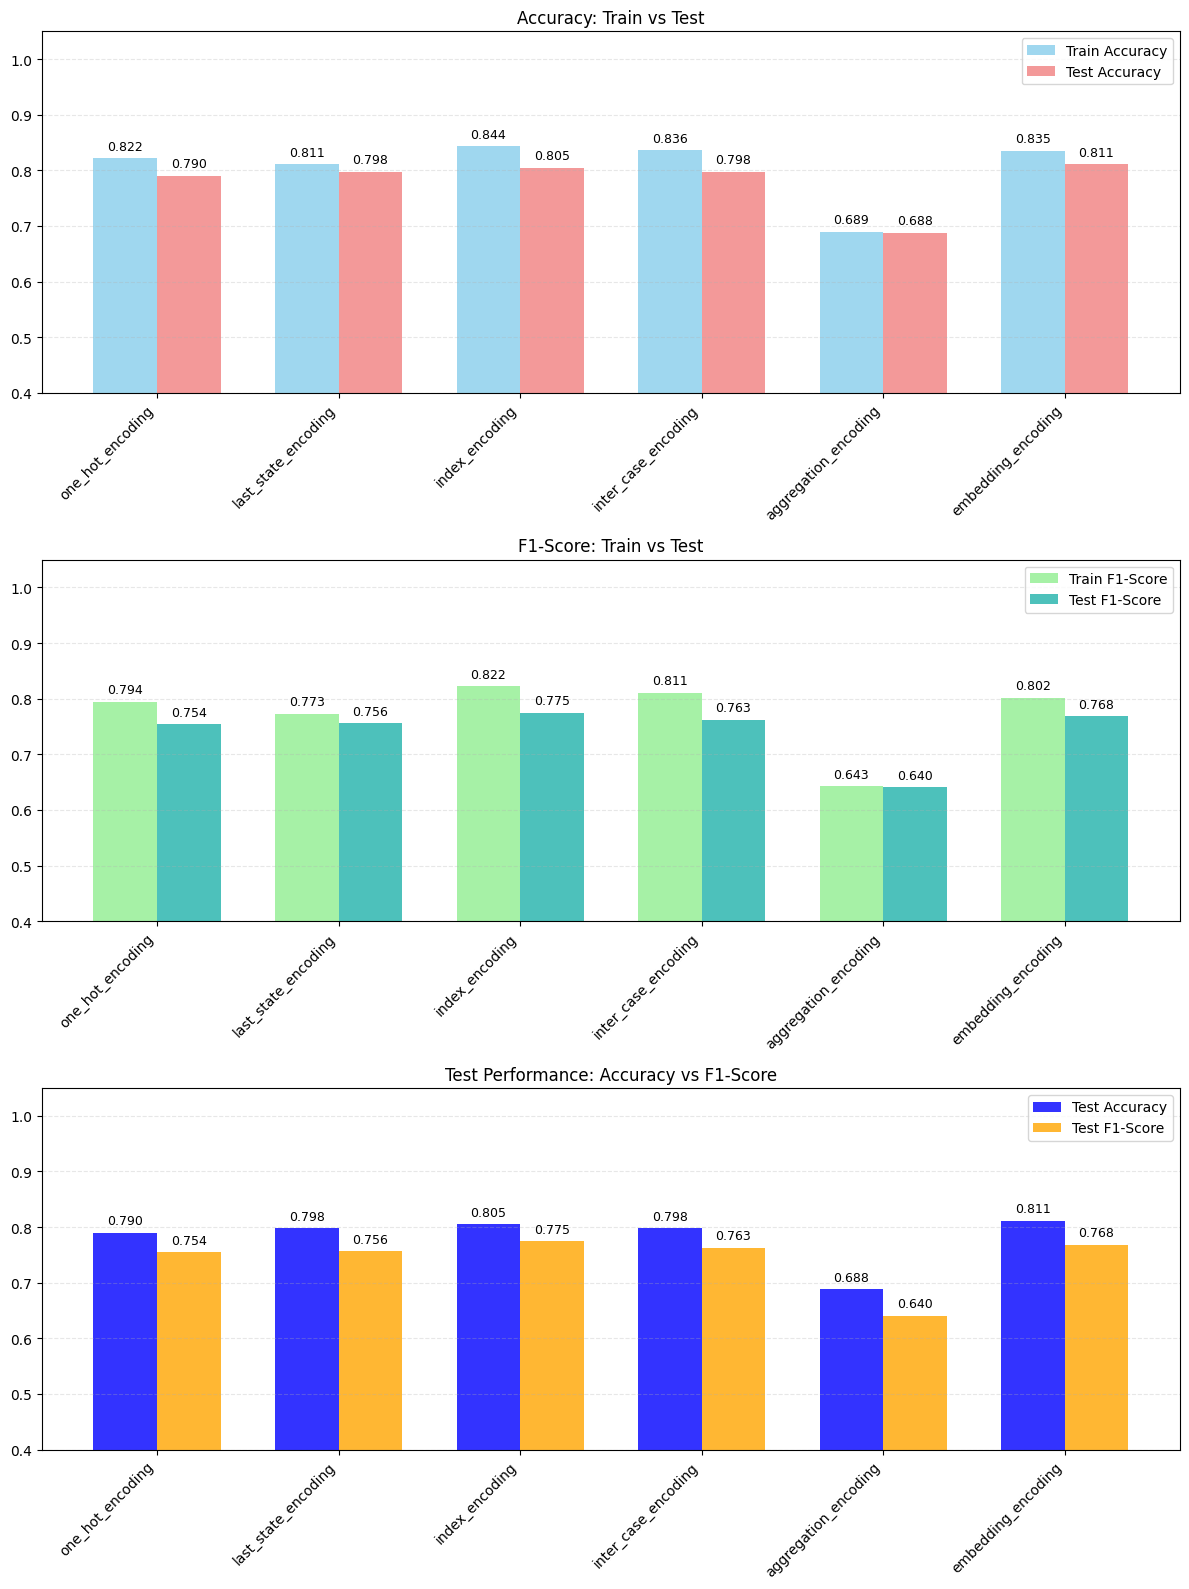

In [26]:
encodings = [result["encoding"] for result in results]

train_accuracies = [result["train_accuracy"] for result in results]
test_accuracies = [result["test_accuracy"] for result in results]

train_f1_scores = [result["train_f1"] for result in results]
test_f1_scores = [result["test_f1"] for result in results]

x = np.arange(len(encodings))
width = 0.35
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 16))

# Accuracy subplot
bars1_train = ax1.bar(x - width/2, train_accuracies, width, label="Train Accuracy", alpha=0.8, color="skyblue")
bars1_test = ax1.bar(x + width/2, test_accuracies, width, label="Test Accuracy", alpha=0.8, color="lightcoral")

for i, (bar_train, bar_test) in enumerate(zip(bars1_train, bars1_test)):
    ax1.text(bar_train.get_x() + bar_train.get_width()/2, bar_train.get_height() + 0.01, 
            f"{train_accuracies[i]:.3f}", ha="center", va="bottom", fontsize=9)
    ax1.text(bar_test.get_x() + bar_test.get_width()/2, bar_test.get_height() + 0.01, 
            f"{test_accuracies[i]:.3f}", ha="center", va="bottom", fontsize=9)

ax1.set_title("Accuracy: Train vs Test")
ax1.set_xticks(x)
ax1.set_xticklabels(encodings, rotation=45, ha="right")
ax1.set_ylim(0.4, 1.05)
ax1.set_yticks(np.arange(0.4, 1.1, 0.1))
ax1.grid(axis="y", linestyle="--", alpha=0.3)
ax1.legend()

# F1-Score subplot
bars2_train = ax2.bar(x - width/2, train_f1_scores, width, label="Train F1-Score", alpha=0.8, color="lightgreen")
bars2_test = ax2.bar(x + width/2, test_f1_scores, width, label="Test F1-Score", alpha=0.8, color="lightseagreen")

for i, (bar_train, bar_test) in enumerate(zip(bars2_train, bars2_test)):
    ax2.text(bar_train.get_x() + bar_train.get_width()/2, bar_train.get_height() + 0.01, 
            f"{train_f1_scores[i]:.3f}", ha="center", va="bottom", fontsize=9)
    ax2.text(bar_test.get_x() + bar_test.get_width()/2, bar_test.get_height() + 0.01, 
            f"{test_f1_scores[i]:.3f}", ha="center", va="bottom", fontsize=9)

ax2.set_title("F1-Score: Train vs Test")
ax2.set_xticks(x)
ax2.set_xticklabels(encodings, rotation=45, ha="right")
ax2.set_ylim(0.4, 1.05)
ax2.set_yticks(np.arange(0.4, 1.1, 0.1))
ax2.grid(axis="y", linestyle="--", alpha=0.3)
ax2.legend()

# Test only subplot (Accuracy vs F1-Score)
bars3_acc = ax3.bar(x - width/2, test_accuracies, width, label="Test Accuracy", alpha=0.8, color="blue")
bars3_f1 = ax3.bar(x + width/2, test_f1_scores, width, label="Test F1-Score", alpha=0.8, color="orange")

for i, (bar_acc, bar_f1) in enumerate(zip(bars3_acc, bars3_f1)):
    ax3.text(bar_acc.get_x() + bar_acc.get_width()/2, bar_acc.get_height() + 0.01, 
            f"{test_accuracies[i]:.3f}", ha="center", va="bottom", fontsize=9)
    ax3.text(bar_f1.get_x() + bar_f1.get_width()/2, bar_f1.get_height() + 0.01, 
            f"{test_f1_scores[i]:.3f}", ha="center", va="bottom", fontsize=9)

ax3.set_title("Test Performance: Accuracy vs F1-Score")
ax3.set_xticks(x)
ax3.set_xticklabels(encodings, rotation=45, ha="right")
ax3.set_ylim(0.4, 1.05)
ax3.set_yticks(np.arange(0.4, 1.1, 0.1))
ax3.grid(axis="y", linestyle="--", alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()

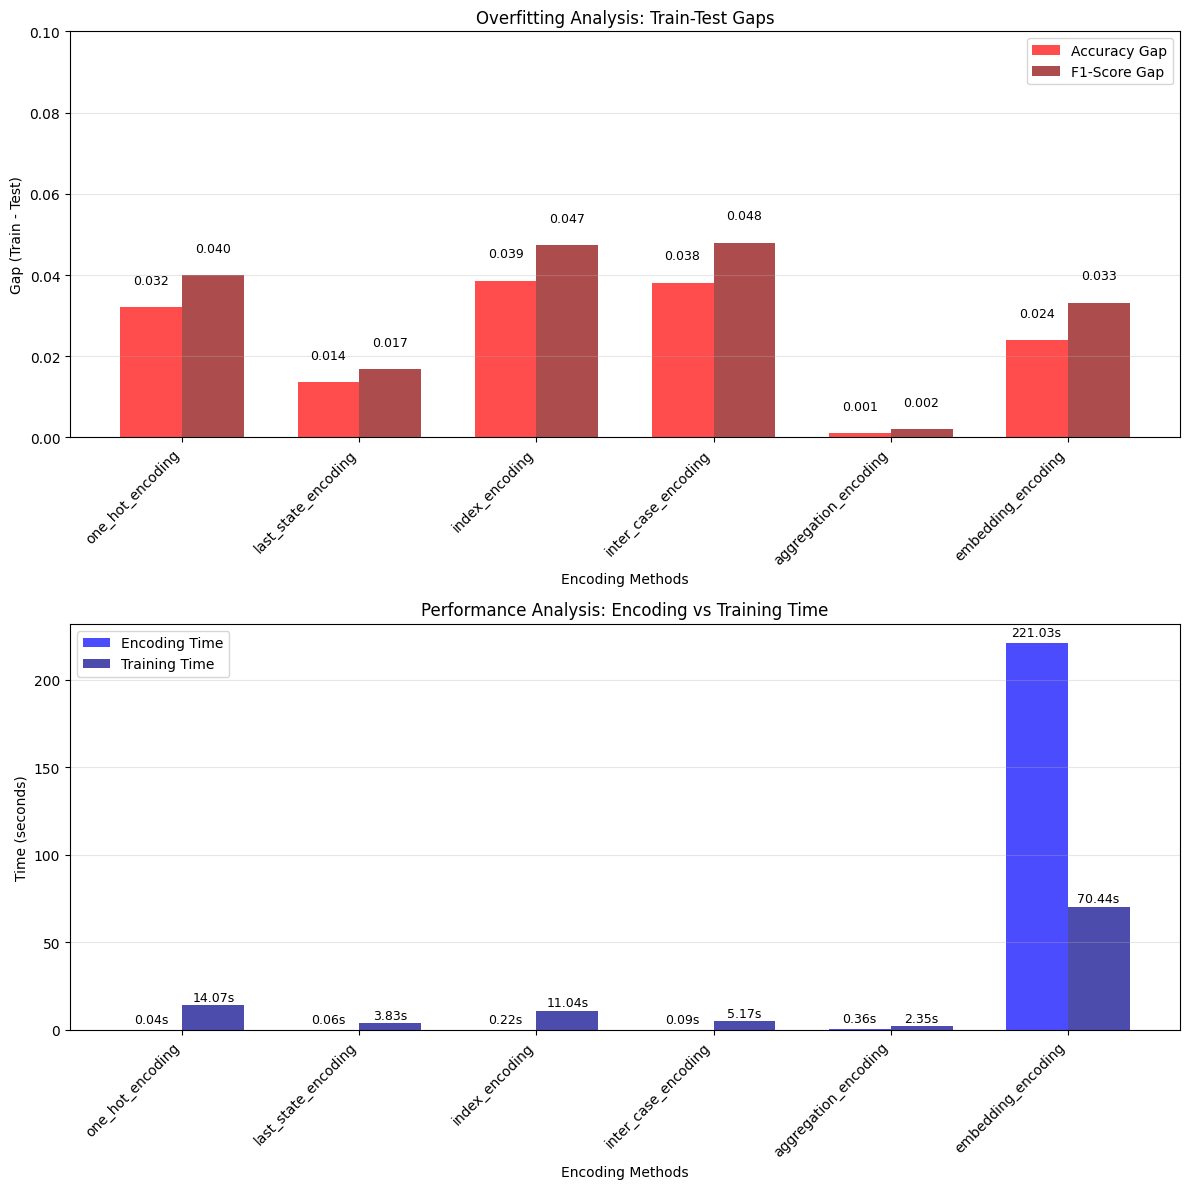

In [27]:
encodings = [result["encoding"] for result in results]
accuracy_gaps = [result["accuracy_gap"] for result in results]
f1_gaps = [result["f1_gap"] for result in results]
encoding_times = [result["encoding_time"] for result in results]
training_times = [result["training_time"] for result in results]

x = np.arange(len(encodings))
width = 0.35
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# overfitting analysis
bars1 = ax1.bar(x - width/2, accuracy_gaps, width, label="Accuracy Gap", color="red", alpha=0.7)
bars2 = ax1.bar(x + width/2, f1_gaps, width, label="F1-Score Gap", color="darkred", alpha=0.7)

for i, bar in enumerate(bars1):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f"{accuracy_gaps[i]:.3f}", ha="center", va="bottom", fontsize=9)
for i, bar in enumerate(bars2):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f"{f1_gaps[i]:.3f}", ha="center", va="bottom", fontsize=9)

ax1.set_ylim(0, 0.1)
ax1.set_title("Overfitting Analysis: Train-Test Gaps")
ax1.set_xlabel("Encoding Methods")
ax1.set_ylabel("Gap (Train - Test)")
ax1.set_xticks(x)
ax1.set_xticklabels(encodings, rotation=45, ha="right")
ax1.legend()
ax1.grid(axis="y", alpha=0.3)

# performance analysis
bars3 = ax2.bar(x - width/2, encoding_times, width, label="Encoding Time", color="blue", alpha=0.7)
bars4 = ax2.bar(x + width/2, training_times, width, label="Training Time", color="darkblue", alpha=0.7)

for i, bar in enumerate(bars3):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(encoding_times)*0.01, 
             f"{encoding_times[i]:.2f}s", ha="center", va="bottom", fontsize=9)
for i, bar in enumerate(bars4):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(training_times)*0.01, 
             f"{training_times[i]:.2f}s", ha="center", va="bottom", fontsize=9)

ax2.set_title("Performance Analysis: Encoding vs Training Time")
ax2.set_xlabel("Encoding Methods")
ax2.set_ylabel("Time (seconds)")
ax2.set_xticks(x)
ax2.set_xticklabels(encodings, rotation=45, ha="right")
ax2.legend()
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()